Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Manuela Bastidas Olivares y Nicolás Guarín-Zapata 2024.

# Método de colocación con PyTorch

En este notebook se implementa el método de colocación
minimizando el error cuadrático medio del residual
en los puntos de colocación.

Adicionalmente, se hace uso de la diferenciación automática
para calcular el residual.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad
import time

## Problema a resolver

Queremos resolver la siguiente ecuación diferencial

$$\frac{d^2u}{dx^2} + u + x = 0 \enspace , $$

con condiciones de frontera $u(0)=u(1)=0$, que tiene
como solución exacta

$$u_e(x) = \frac{\sin(x)}{\sin(1)} - x \, .$$

## Función de aproximación propuesta

En este caso, hacemos uso de una función de aproximación
polinómica

$$u_N(x) = \sum_{i=0}^N c_i \phi_i(x) = x (1-x) \sum_{i=0}^N c_i x^i\, ,$$

en donde vemos que esta función satisface las condiciones de frontera.

In [13]:
def funcion_aprox(x, c):
    """Función de aproximación con coeficientes c y variable x"""
    terms = [coef * x**(i + 1) * (x -1) for i, coef in enumerate(c)]
    return torch.sum(torch.stack(terms), dim=0)


Y el residual estaría dado por

$$R = \frac{d^2 u_N}{dx^2} + u_N + x\, .$$


## Uso de diferenciación automática

En lugar de calcular el residuo análiticamente se obtiene con diferenciación automática.

In [14]:
# Derivada
def derivative(dy, x, order=1):
    for _ in range(order):
        dy = grad(dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True)[0]
    return dy

# Residuo
def residuo(x, c):
    return derivative(funcion_aprox(x, c), x, order=2) + funcion_aprox(x, c) + x

# Función de pérdida: error cuadrático medio
def loss_fn(x, c):
    res = residuo(x, c)
    return torch.mean(res ** 2) 


# Inicialización de coeficientes de forma aleatoria
def initialize_coefficients(n):
    std_dev = 1.0 / torch.sqrt(torch.tensor(n, dtype=torch.float32))
    return torch.randn(n, dtype=torch.float64) * std_dev

In [15]:
npts = 11
x_coloc = torch.tensor([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                       dtype=torch.float64, requires_grad=True)


c = initialize_coefficients(npts).requires_grad_(True)

In [16]:
x_coloc

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000], dtype=torch.float64, requires_grad=True)

In [17]:
# # Configuración del optimizador
# optimizer = torch.optim.Adam([c], lr=0.1)

# # Bucle de entrenamiento
# num_epochs = 1_000
# losses = []
# for epoch in range(num_epochs):
#     optimizer.zero_grad()  # Limpiar gradientes previos
#     current_loss = loss_fn(x_coloc, c)  # Calcular la pérdida
#     losses.append(current_loss.item())
#     current_loss.backward()  # Calcular gradientes
#     optimizer.step()  # Actualizar parámetros

#     if epoch % 100 == 0:  # Mostrar progreso cada 1000 épocas
#         print(f'Epoch {epoch}, Loss: {current_loss.item():g}')

# # Resultados optimizados
# print(f'Optimized c: {c.data}') 

In [18]:
# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS([c],
                                lr=1,
                                max_iter=10_000,
                                max_eval=10_000,
                                tolerance_grad=1e-6,
                                history_size=50,
                                tolerance_change=1.0 * np.finfo(float).eps,
                                line_search_fn=None)
 

# Definir la función de cierre
iter_count=0
losses = []
def closure():
    global iter_count
    iter_count+=1
    optimizer.zero_grad()
    loss = loss_fn(x_coloc,c)
    losses.append(loss.item()) 
    if iter_count % 100 == 0: 
        print(f'iter {iter_count}, loss: {loss.detach().numpy()}')
    loss.backward(retain_graph=True)
    return loss

# Función para entrenar el modelo
def train_model():
    start_time = time.time()
    optimizer.step(closure)
    end_time = time.time()
    loss = loss_fn(x_coloc,c) 
    print(f'Final loss: {loss.detach().numpy()}')
    print(f'Tiempo de entrenamiento: {end_time - start_time} segundos')

# Entrenar el modelo
train_model()

iter 100, loss: 1.1554375692705842e-05
iter 200, loss: 1.1088446097747934e-05
iter 300, loss: 1.0641510129558885e-05
iter 400, loss: 1.0212793510846252e-05
iter 500, loss: 9.801553527815477e-06
iter 600, loss: 9.407077743482867e-06
iter 700, loss: 9.028682763434967e-06
iter 800, loss: 8.665713051910619e-06
iter 900, loss: 8.317539796132015e-06
iter 1000, loss: 7.983559816948433e-06
iter 1100, loss: 7.66319452387032e-06
iter 1200, loss: 7.355888912713995e-06
iter 1300, loss: 7.06111060410485e-06
iter 1400, loss: 6.77834892116967e-06
iter 1500, loss: 6.507114004834901e-06
iter 1600, loss: 6.246935965188531e-06
iter 1700, loss: 5.997364067428785e-06
iter 1800, loss: 5.757965951011692e-06
iter 1900, loss: 5.52832688061658e-06
iter 2000, loss: 5.308049027654306e-06
iter 2100, loss: 5.096750781062299e-06
iter 2200, loss: 4.894066086194816e-06
iter 2300, loss: 4.699643810665038e-06
iter 2400, loss: 4.51314713603515e-06
iter 2500, loss: 4.33425297430948e-06
iter 2600, loss: 4.1626514082101555e

Gráfica de la predicción obtenida.

In [19]:
x =torch.tensor([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])#torch.linspace(0, 1, steps=10)
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x

Text(0, 0.5, 'u(x)')

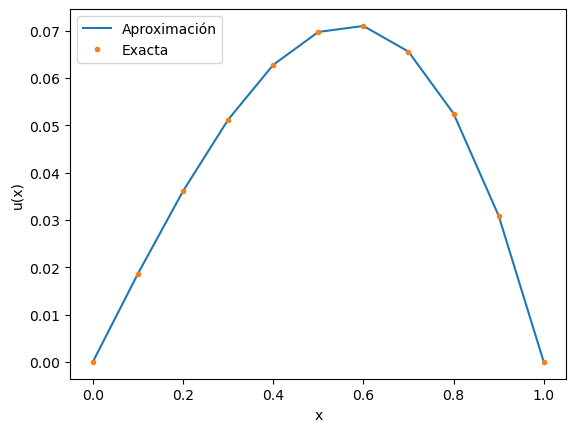

In [20]:
fig = plt.figure()
plt.plot(x, y_pred)
plt.plot(x, y_true, ".")
plt.legend(['Aproximación', 'Exacta'])
plt.xlabel("x")
plt.ylabel("u(x)")

Gráfica el residuo obtenido luego de la optimización.

Text(0.5, 0, 'x')

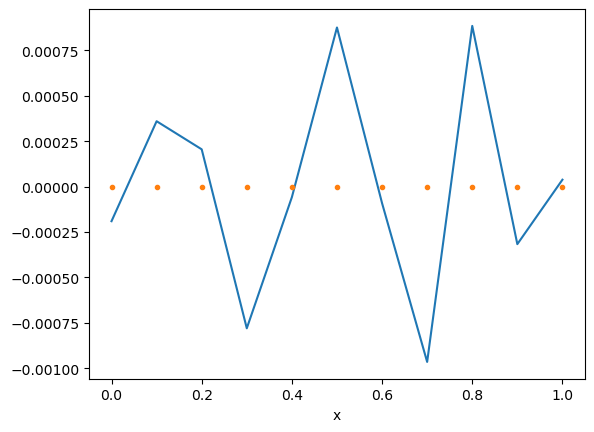

In [21]:
x.requires_grad_(True)

fig = plt.figure()
plt.plot(x.detach().numpy(), residuo(x, c).detach().numpy())
plt.plot(x_coloc.detach().numpy(), [0]*npts, ".")
plt.xlabel("x")


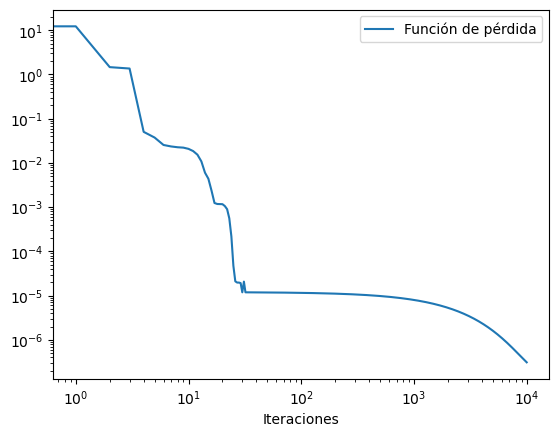

In [22]:
fig, ax = plt.subplots()
plt.loglog(losses)
plt.xlabel("Iteraciones")
plt.legend(['Función de pérdida'])